# Example for system in Cugno et al 2019

Geometry is divided into 4 domains; two volumes and two surfaces:
- plasma membrane (PM)
- Cytosol
- ER membrane
- ER lumen (inside the ER)

This model has a single species, $\text{Ca}^{2+}$, with prescribed time-dependent fluxes at the PM and the ERM.

There are three reactions:
- $\text{Ca}^{2+}$ influx at the PM
- $\text{Ca}^{2+}$ removal in the cytosol (e.g. via buffering)
- $\text{Ca}^{2+}$ flux into the ER  
```

In [ ]:
import dolfin as d
import sympy as sym
import numpy as np

from stubs import unit, config, common, mesh, model
from stubs.model_assembly import Compartment, Parameter, Reaction, Species

import os

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

First, we define the various units for the inputs

In [ ]:
# Aliases - base units
uM = unit.uM
um = unit.um
molecule = unit.molecule
sec = unit.sec
dimensionless = unit.dimensionless
# Aliases - units used in model
D_unit = um**2 / sec
flux_unit = uM * um / sec
vol_unit = uM
surf_unit = molecule / um**2

Next we generate the model.

In [ ]:
def make_model(curRadius):
    # =============================================================================================
    # Species
    # =============================================================================================
    # name, initial concentration, concentration units, diffusion, diffusion units, compartment
    Ca = Species("Ca", 0.05, vol_unit, 100.0, D_unit, "Cyto")
    CaER = Species("CaER", 150.0, vol_unit, 6.27, D_unit, "ER") #effective D due to buffering
    # note that CaER is not required; it is passively determined by the prescribed flux into the ER
    # but for SMART to solve the system right now, it requires at least two species

    # =============================================================================================
    # Compartments
    # =============================================================================================
    # name, topological dimensionality, length scale units, marker value
    Cyto = Compartment("Cyto", 3, um, 1)
    PM = Compartment("PM", 2, um, 10)
    ER = Compartment("ER", 3, um, 2)
    ERm = Compartment("ERm", 2, um, 12)

    PM.specify_nonadjacency(['ERm', 'ER'])
    ERm.specify_nonadjacency(['PM'])

    # =============================================================================================
    # Parameters and Reactions
    # =============================================================================================
    # Ca2+ influx at membrane
    gamma, alpha, beta = 1140.0, .0025, .002
    t = sym.symbols("t")
    pulsePM = gamma*(sym.exp(-t/alpha) - sym.exp(-t/beta))
    #pulsePM_I = gamma*(-alpha*sym.exp(-t/alpha) + beta*sym.exp(-t/beta)) # integral for preintegration
    j1pulse = Parameter.from_expression(
        "j1pulse", pulsePM, flux_unit, use_preintegration=False#, preint_sym_expr=pulsePM_I
        )
    #Ca0 = Parameter("Ca0", 100, vol_unit)
    r1 = Reaction(
        "r1",
        [],
        ["Ca"],
        param_map={"J": "j1pulse"},
        eqn_f_str="J",
        explicit_restriction_to_domain="PM",
    )
    # Ca2+ flux into the ER
    zeta, tER = 0.2, .02
    estep = lambda t,t0,m: 1 / (1+sym.exp(m*(t0-t)))
    pulseER = zeta*gamma*estep(t,tER,8000)*(sym.exp(-(t-tER)/alpha) - sym.exp(-(t-tER)/beta))
    #pulseER_I = zeta*gamma*(-alpha*sym.exp(-(t-tER)/alpha) + beta*sym.exp(-(t-tER)/beta)) # integral for preintegration
    j2pulse = Parameter.from_expression(
        "j2pulse", pulseER, flux_unit, use_preintegration=False#, preint_sym_expr=pulseER_I
        )
    r2 = Reaction(
        "r2",
        ["CaER"],
        ["Ca"],
        param_map={"J": "j2pulse"},
        eqn_f_str="J",
        explicit_restriction_to_domain="ERm",
    )
    # consumption of Ca in the cytosol
    tau = Parameter("tau", 0.05, sec)
    r3 = Reaction("r3", ["Ca"], [], param_map={"tau": "tau"},
         eqn_f_str="Ca/tau", species_map={"Ca": "Ca"})
    # scale fluxes into the ER to implicitly account for buffers
    # xi = 0.0227272727
    # r2.flux_scaling = {"CaER": xi}
    # r2.__post_init__()

    # =============================================================================================
    # Gather all parameters, species, compartments and reactions
    # =============================================================================================
    return common.sbmodel_from_locals(locals().values())

We load the model generated above, and load in the mesh we will use in this example.

In [ ]:
curRadius = 0.25 # dendritic spine radius
pc, sc, cc, rc = make_model(curRadius)

# =============================================================================================
# Create/load in mesh
# =============================================================================================
# Base mesh
domain, facet_markers, cell_markers = common.DemoSpheresMesh(curRadius, curRadius/2, hEdge=0.01) 
# Write mesh and meshfunctions to file
os.makedirs(f"mesh", exist_ok=True)
common.write_mesh(domain, facet_markers, cell_markers, filename=f"mesh/DemoSphere")

# # Define solvers
parent_mesh = mesh.ParentMesh(
    mesh_filename=f"mesh/DemoSphere.h5",
    mesh_filetype="hdf5",
    name="parent_mesh",
)
configCur = config.Config()
modelCur = model.Model(pc, sc, cc, rc, configCur, parent_mesh)
configCur.solver.update(
    {
        "final_t": 0.1,
        "initial_dt": 0.001,
        "time_precision": 6,
        "use_snes": True,
        "print_assembly": False,
    }
)

modelCur.initialize(initialize_solver=False)
modelCur.initialize_discrete_variational_problem_and_solver()


In [ ]:
# Write initial condition(s) to file
results = dict()
os.makedirs(f"results", exist_ok=True)
for species_name, species in modelCur.sc.items:
    results[species_name] = d.XDMFFile(
        modelCur.mpi_comm_world, f"results/{species_name}.xdmf"
    )
    results[species_name].parameters["flush_output"] = True
    results[species_name].write(modelCur.sc[species_name].u["u"], modelCur.t)

concVec = np.array([.05])
# Solve
while True:
    # Solve the system
    modelCur.monolithic_solve()
    # Save results for post processing
    for species_name, species in modelCur.sc.items:
        results[species_name].write(modelCur.sc[species_name].u["u"], modelCur.t)
    # save mean value at r = (curRadius + curRadius/2)/2 (for comparison to Cugno graph below)
    cytoMesh = domain = modelCur.cc['Cyto'].dolfin_mesh
    integrateDomain = d.MeshFunction("size_t", cytoMesh, 3, 0)
    RTarget = (curRadius + curRadius/2) / 2
    for c in d.cells(cytoMesh):
        RCur = np.sqrt(c.midpoint().x()**2 + c.midpoint().y()**2 + c.midpoint().z()**2)
        integrateDomain[c] = 1 if (RCur > RTarget-.1*curRadius and RCur < RTarget + .1*curRadius) else 0
    dx = d.Measure("dx", domain=cytoMesh, subdomain_data = integrateDomain)
    int_val = d.assemble(modelCur.sc['Ca'].u['u']*dx(1))
    volume = d.assemble(1.0*dx(1))
    curConc = np.array([int_val / volume])
    concVec = np.concatenate((concVec, curConc))
    np.savetxt(f"results/tvec.txt", np.array(modelCur.tvec).astype(np.float32))
    # End if we've passed the final time
    if modelCur.t >= modelCur.final_t:
        break

Text(0.5, 1.0, 'SMART simulation')

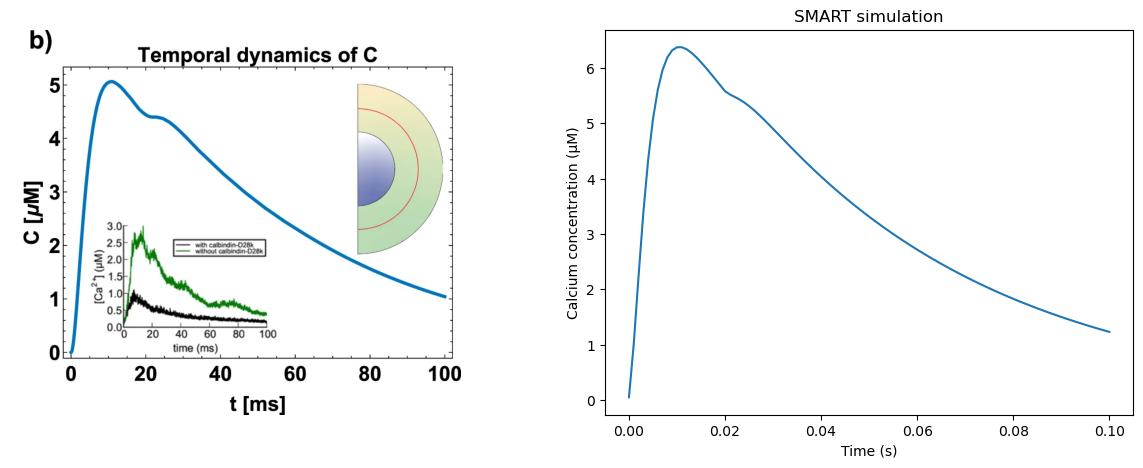

In [8]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 5
# read image from Fig 3b of paper
img_A = mpimg.imread('Cugno_et_al_2019_Fig3b.png')
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[0].axis('off')
ax[1].plot(modelCur.tvec, concVec)
plt.xlabel("Time (s)")
plt.ylabel("Calcium concentration (μM)")
plt.title("SMART simulation")